Data Science

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import random
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam

In [2]:
#load dataset
df = pd.read_csv('/Users/rafiandrianto/Desktop/DataScience/data/TheDataV2.csv')
df.head()

,FID,Date,Latitude,Longitude,Oceans,Regions,SubRegions,Measurement,Unit,Density Range,...,State,Country,Marine Setting,x,y,Time,Wind Direction,Wind Speed (km/h),Ocean Current Direction,Ocean Current Speed (km/h)
0,115197,01/01/2014,9.338500,-82.239900,Atlantic Ocean,Caribbean Sea,NaN,0.027000,pieces/m3,0.005-1,...,NaN,NaN,Ocean water,-9.154904e+06,1.044190e+06,12:00,320.0,9.0,130.0,2.59
1,115198,01/02/2014,11.471700,-86.131400,Pacific Ocean,NaN,NaN,0.006000,pieces/m3,0.005-1,...,NaN,NaN,Ocean water,-9.588104e+06,1.285642e+06,12:00,60.0,28.0,315.0,1.58
2,115199,01/03/2014,20.396200,-87.313200,Atlantic Ocean,Caribbean Sea,NaN,0.004000,pieces/m3,0.0005-0.005,...,NaN,NaN,Ocean water,-9.719661e+06,2.320026e+06,12:00,80.0,18.0,20.0,0.58
3,120425,01/06/2014,56.136000,-2.690167,Atlantic Ocean,North Sea,NaN,0.140195,pieces/m3,0.005-1,...,NaN,NaN,Ocean water,-2.994680e+05,7.585537e+06,12:00,180.0,24.0,230.0,0.11
4,120424,01/06/2014,56.086333,-2.839667,Atlantic Ocean,North Sea,NaN,0.084671,pieces/m3,0.005-1,...,NaN,NaN,Ocean water,-3.161103e+05,7.575621e+06,12:00,180.0,23.0,NaN,NaN


In [3]:
#dropping columns because they are not useful or mostly empty
columns_to_drop = [
    'FID', 'Unit', 'Short Reference', 'DOI', 'Organization', 'Keywords', 
    'Accession Number', 'Accession Link', 'GlobalID', 'Long Reference',
    'Beach Location', 'State', 'Country', 'Sampling Point on Beach', 
    'Transect Number', 'x', 'y', 'Ocean Bottom Depth (m)', 
    'Sediment Sample Depth (m)', 'Volunteers Number', 'Collecting Time (min)',
    'Sampling Method', 'Density Range', 'Oceans', 'Regions', 
    'Marine Setting', 'Time', 'SubRegions', 
]

#drop the columns
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

df.head()

,Date,Latitude,Longitude,Measurement,Density Class,Wind Direction,Wind Speed (km/h),Ocean Current Direction,Ocean Current Speed (km/h)
0,01/01/2014,9.338500,-82.239900,0.027000,Medium,320.0,9.0,130.0,2.59
1,01/02/2014,11.471700,-86.131400,0.006000,Medium,60.0,28.0,315.0,1.58
2,01/03/2014,20.396200,-87.313200,0.004000,Low,80.0,18.0,20.0,0.58
3,01/06/2014,56.136000,-2.690167,0.140195,Medium,180.0,24.0,230.0,0.11
4,01/06/2014,56.086333,-2.839667,0.084671,Medium,180.0,23.0,NaN,NaN


In [4]:
#checking for missing values and number of datapoints
print(df.isna().sum())
print(df.shape)

Date                             0
Latitude                         0
Longitude                        0
Measurement                   5815
Density Class                    0
Wind Direction                   2
Wind Speed (km/h)                2
Ocean Current Direction        714
Ocean Current Speed (km/h)     714
dtype: int64
(11300, 9)


In [5]:
#dropping rows with missing values
df.dropna(inplace=True)
#check if there are missing values again
print(df.isna().sum())
print(df.shape)

Date                          0
Latitude                      0
Longitude                     0
Measurement                   0
Density Class                 0
Wind Direction                0
Wind Speed (km/h)             0
Ocean Current Direction       0
Ocean Current Speed (km/h)    0
dtype: int64
(5182, 9)


In [6]:
#checking the distribution of 'Measurement', 'Wind Speed (km/h)', and 'Ocean Current Speed (km/h)'
measurement_distribution = df['Measurement'].describe()
wind_speed_distribution = df['Wind Speed (km/h)'].describe()
ocean_current_speed_distribution = df['Ocean Current Speed (km/h)'].describe()

measurement_distribution, wind_speed_distribution, ocean_current_speed_distribution

(count      5182.000000
 mean        471.996246
 std        3676.178811
 min           0.000000
 25%           0.007000
 50%           0.192082
 75%           3.213966
 max      110480.000000
 Name: Measurement, dtype: float64,
 count    5182.000000
 mean       23.496140
 std        13.414577
 min         1.000000
 25%        13.000000
 50%        22.000000
 75%        33.000000
 max        86.000000
 Name: Wind Speed (km/h), dtype: float64,
 count    5182.000000
 mean        0.452345
 std         0.624512
 min         0.000000
 25%         0.180000
 50%         0.320000
 75%         0.540000
 max        10.150000
 Name: Ocean Current Speed (km/h), dtype: float64)

In [7]:
#applying log transformation to the 'Measurement' variable to make it more normally distributed (handling the skewness)
#adding 1 to the 'Measurement' variable to avoid log(0) error
df['Measurement Log'] = np.log(df['Measurement'] + 1)

#checking the distribution of the transformed 'Measurement' variable
transformed_measurement_distribution = df['Measurement Log'].describe()
transformed_measurement_distribution

count    5182.000000
mean        1.441634
std         2.472253
min         0.000000
25%         0.006976
50%         0.175701
75%         1.438404
max        11.612599
Name: Measurement Log, dtype: float64

In [8]:
#fill empty values in 'Ocean Current Speed' with the mean value
#df['Ocean Current Speed (km/h)'].fillna(df['Ocean Current Speed (km/h)'].mean(), inplace=True)

#drop empty values in 'Ocean Current Speed'
df.dropna(subset=['Ocean Current Speed (km/h)'], inplace=True)

In [9]:
#convert 'Date' from string to datetime and extract components
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [10]:
#convert 'Wind Direction' and 'Ocean Current Direction' into sine and cosine components
df['Wind Direction (sin)'] = np.sin(np.radians(df['Wind Direction']))
df['Wind Direction (cos)'] = np.cos(np.radians(df['Wind Direction']))
df['Ocean Current Direction (sin)'] = np.sin(np.radians(df['Ocean Current Direction'].fillna(0)))
df['Ocean Current Direction (cos)'] = np.cos(np.radians(df['Ocean Current Direction'].fillna(0)))

In [11]:
#assign numerical values to 'Density Class'
density_class_mapping = {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
df['Density Score'] = df['Density Class'].map(density_class_mapping)

In [12]:
#dropping another columns that are not needed
columns_to_drop = ['Density Class', 'Date', 'Wind Direction', 'Ocean Current Direction', 'Measurement']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,Latitude,Longitude,Wind Speed (km/h),Ocean Current Speed (km/h),Measurement Log,Year,Month,Day,Wind Direction (sin),Wind Direction (cos),Ocean Current Direction (sin),Ocean Current Direction (cos),Density Score
0,9.3385,-82.239900,9.0,2.59,0.026642,2014,1,1,-6.427876e-01,0.766044,0.766044,-0.642788,2
1,11.4717,-86.131400,28.0,1.58,0.005982,2014,1,2,8.660254e-01,0.500000,-0.707107,0.707107,2
2,20.3962,-87.313200,18.0,0.58,0.003992,2014,1,3,9.848078e-01,0.173648,0.342020,0.939693,1
3,56.1360,-2.690167,24.0,0.11,0.131199,2014,1,6,1.224647e-16,-1.000000,-0.766044,-0.642788,2
5,20.2103,-87.430200,17.0,0.36,0.001998,2014,1,7,9.848078e-01,0.173648,0.965926,0.258819,1


Random Forest Regressor

In [13]:
X = df.drop('Measurement Log', axis=1) #to make all columns except 'Measurement_Log'
y = df['Measurement Log']  #make to target variable

In [14]:
#using seed for reproducibility for getting the same result anytime
SEED = 4
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [15]:
#split the data into training and testing. the split is 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [16]:
'''
creating a hyperparameter grid for Random Forest Regressor. this is done to find the best parameters for the model.
'''
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)], #setting number of trees
    'max_features': ['sqrt', None], #setting number of features to consider at every split
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None], #setting maximum number of levels in tree
    'min_samples_split': [2, 5, 10], #setting minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4], #setting minimum number of samples required at each leaf node
    'bootstrap': [True, False] #setting method of selecting samples for training each tree
}

#initialize the model
rf = RandomForestRegressor()

#using RandomizedSearchCV to find the best parameter
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=SEED, n_jobs=-1, error_score='raise')

In [17]:
#fitting the model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[CV] END bootstrap=True, max_depth=60, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   5.1s
[CV] END bootstrap=True, max_depth=60, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   5.3s
[CV] END bootstrap=True, max_depth=60, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   5.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  13.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  13.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  13.4s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=110, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=  19.3s
[CV] END bootstrap=True, max_depth=110, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=  19.8s
[CV] END bootstrap=True, max_depth=110, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=  19.8s
[CV] END bootstrap=True, max_depth=80, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   4.3s
[CV] END bootstrap=True, max_depth=80, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   4.4s
[CV] END bootstrap=False, max_depth=80, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  19.1s
[CV] END bootstrap=False, max_depth=80, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  19.7s
[CV] END bootstrap=False, max_depth=

RandomizedSearchCV(cv=3, error_score='raise', estimator=RandomForestRegressor(),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=4, verbose=2)

In [18]:
#evaluate the best model
best_rf = rf_random.best_estimator_  #getting the best model from RandomizedSearchCV
y_pred = best_rf.predict(X_test)  #using the best model to make predictions on the test set

#calculating the metrics
mse = mean_squared_error(y_test, y_pred) #calculating mean squared error
rmse = np.sqrt(mse) #calculating root mean squared error
mae = np.mean(np.abs(y_pred - y_test)) #calculating mean absolute error
rsq = best_rf.score(X_test, y_test) #calculating r-squared

#printing the result
print(f"RMSE of the best model: {rmse}")
print(f"MAE of the best model: {mae}")
print(f"R-squared of the best model: {rsq}")

RMSE of the best model: 0.6182495308532527
MAE of the best model: 0.3081318967715101
R-squared of the best model: 0.9352213643750245


In [19]:
'''
Creating Cross Validation with KFold to check the model's performance.
we do this to make sure that the model is not overfitting and does not perform well because of chance.
'''
#initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=SEED) #setting the number of splits for

#initialize lists to store scores
rmse_scores = []
mae_scores = []
rsq_scores = [] 

#iterate over each split
for train_index, test_index in kf.split(X):
    #split data into training and test based on the current fold
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    #fit the model to the training data
    best_rf.fit(X_train_kf, y_train_kf)
    
    #predict on the test data
    y_pred_kf = best_rf.predict(X_test_kf)
    
    #calculate RMSE and append to list
    rmse_score = np.sqrt(mean_squared_error(y_test_kf, y_pred_kf))
    rmse_scores.append(rmse_score)
    
    #calculate MAE and append to list
    mae_score = np.mean(np.abs(y_pred_kf - y_test_kf))
    mae_scores.append(mae_score)
    
    #calculate RSQ and append to list
    rsq_score = best_rf.score(X_test_kf, y_test_kf)
    rsq_scores.append(rsq_score)


In [20]:
#print the mean of the RMSE, MAE, and RSQ scores since we have 5 folds
print(f"Mean RMSE: {np.mean(rmse_scores)}")
print(f"Mean MAE: {np.mean(mae_scores)}")
print(f"Mean RSQ: {np.mean(rsq_scores)}")


Mean RMSE: 0.6377372077652235
Mean MAE: 0.3124789195855638
Mean RSQ: 0.9333864548967912


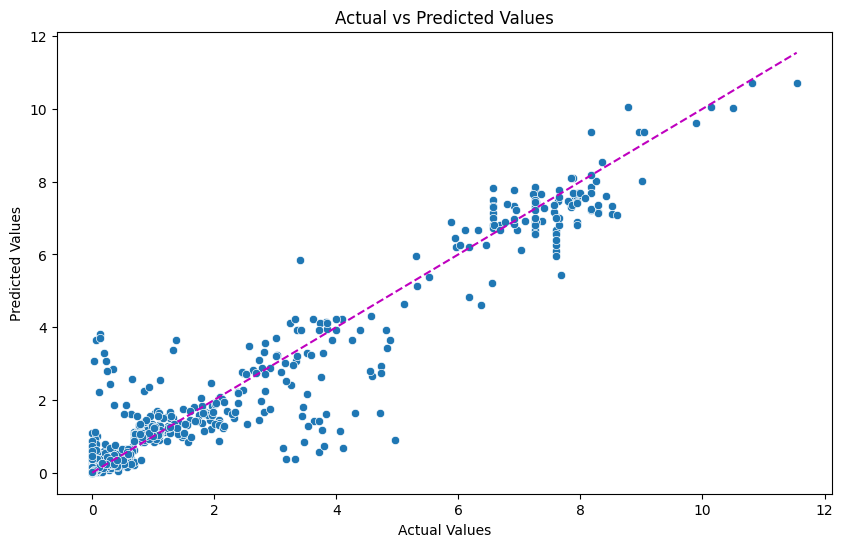

In [21]:
#plotting the actual vs predicted values
plt.figure(figsize=(10, 6)) #setting the size of the figure
sns.scatterplot(x=y_test, y=y_pred) #plotting the scatterplot
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--') #plotting the diagonal line
plt.xlabel('Actual Values') #setting the x label name
plt.ylabel('Predicted Values')  #setting the y label name
plt.title('Actual vs Predicted Values') #title of the plot
plt.show() #showing the plot


LSTM

In [22]:
#standardScaler is used to normalize the features by removing the mean and scaling to unit variance
#we do it for both training and testing set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
#since LSTM models in Keras expect a 3D input shape, we need to reshape the data
#since the time series nature of the data isn't being used (time steps = 1), each sample is a separate sequence.
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [24]:
#build the LSTM model
model = Sequential()

#first layer is 100 units and 'return_sequences=True' is so that the next LSTM layer has a three-dimensional sequence input
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[2])))

#dropout layer to prevent overfitting by ignoring randomly selected neurons during training
model.add(Dropout(0.2))

#second layer is 50 units and the 'return_sequences=False' since no more layers are added after this
model.add(LSTM(50, activation='relu', return_sequences=False))

#another dropout for regularization
model.add(Dropout(0.2))

#dense layer for further processing the LSTM output
model.add(Dense(50, activation='relu'))

#output layer with a single neuron since it's a regression problem
model.add(Dense(1))

#compile the model
#adam optimizer is used because it produces the best result for this model, and mean squared error loss function is for regression
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae', 'mse'])

In [25]:
#train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/data_adapter.py:1798: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


104/104 [==============================] - 1s 3ms/step - loss: 6.2255 - mae: 1.4871 - mse: 6.2255 - val_loss: 3.8326 - val_mae: 1.4484 - val_mse: 3.8326
Epoch 2/100
104/104 [==============================] - 0s 2ms/step - loss: 3.3639 - mae: 1.2217 - mse: 3.3639 - val_loss: 2.9325 - val_mae: 1.0994 - val_mse: 2.9325
Epoch 3/100
104/104 [==============================] - 0s 2ms/step - loss: 2.7160 - mae: 1.0045 - mse: 2.7160 - val_loss: 2.4635 - val_mae: 0.9278 - val_mse: 2.4635
Epoch 4/100
104/104 [==============================] - 0s 2ms/step - loss: 2.2609 - mae: 0.8703 - mse: 2.2609 - val_loss: 2.1098 - val_mae: 0.8511 - val_mse: 2.1098
Epoch 5/100
104/104 [==============================] - 0s 2ms/step - loss: 2.0150 - mae: 0.8351 - mse: 2.0150 - val_loss: 1.8885 - val_mae: 0.7935 - val_mse: 1.8885
Epoch 6/100
104/104 [==============================] - 0s 2ms/step - loss: 1.8125 - mae: 0.7874 - mse: 1.8125 - val_loss: 1.8709 - val_mae: 0.7853 - val_mse: 1.8709
Epoch 7/100
104/104 [=

In [26]:
#evaluate the model
test_loss, test_mae, test_mse = model.evaluate(X_test_scaled, y_test, verbose=0)

#generate predictions
y_pred = model.predict(X_test_scaled)

#calculate the RMSE from the returned MSE and R-squared
rmse_test = np.sqrt(test_mse)
r_squared = r2_score(y_test, y_pred)

#print the result
print(f"Test RMSE: {rmse_test}")
print(f"Test MAE: {test_mae}")
print(f"R-squared: {r_squared}")

33/33 [==============================] - 0s 621us/step
Test RMSE: 0.7160013550180795
Test MAE: 0.3508669137954712
R-squared: 0.91311756959214


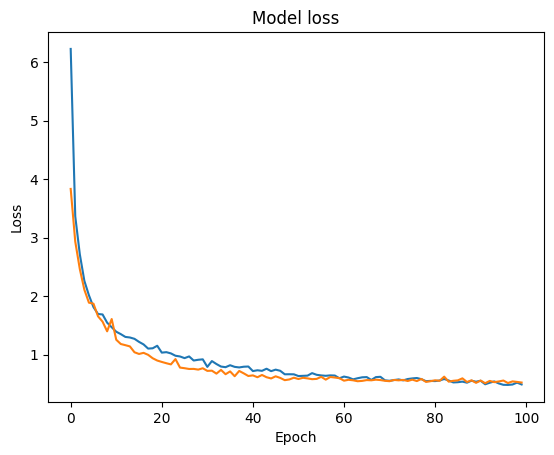

In [27]:
# Optionally, plot the learning curves (loss & validation loss)
plt.plot(history.history['loss'], label='train') #plotting the training loss
plt.plot(history.history['val_loss'], label='validation') #plotting the validation loss
plt.title('Model loss') #title of the plot
plt.ylabel('Loss') #setting the y label name
plt.xlabel('Epoch') #setting the x label name
plt.show() #showing the plot

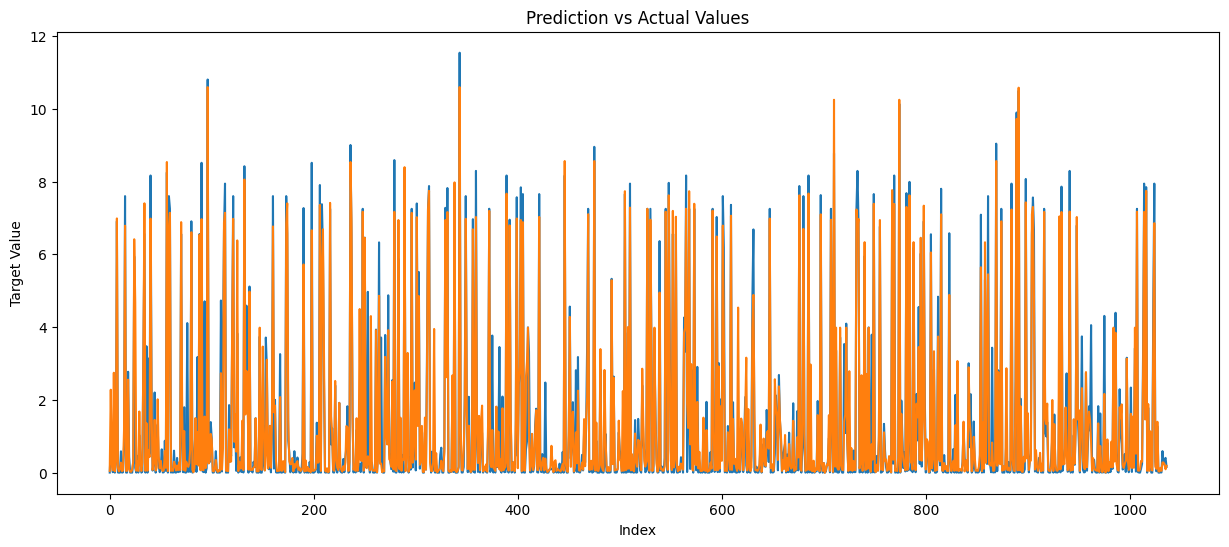

In [29]:
#plot predicted vs actual values
plt.figure(figsize=(15, 6)) #setting the size of the figure
plt.plot(y_test.reset_index(drop=True), label='Actual Values') #reset the index of y_test and plot it
plt.plot(y_pred.flatten(), label='Predicted Values')  #flatten y_pred
plt.xlabel('Index') #setting the x label name
plt.ylabel('Target Value') #setting the y label name
plt.title('Prediction vs Actual Values') #title of the plot
plt.show() #showing the plot

